In [3]:
import asyncio
import time

from math import nan, cos

import numpy as np
import sep
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
from astropy import wcs
from astropy.coordinates import SkyCoord

from photutils.datasets import make_100gaussians_image
from photutils.background import Background2D, MedianBackground

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.centroids import centroid_sources
from photutils.centroids import centroid_com, centroid_quadratic
from photutils.centroids import centroid_1dg, centroid_2dg

from plotimg import plot_images
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection
from lvmagp.focus.focusseries import ProjectionFocusSeries, PhotometryFocusSeries

from lvmagp.focus.curvefit import fit_hyperbola

from IPython.display import display, clear_output

from lvmtipo.wcsarith import Wcsarith


In [4]:
from lvmtipo.actors import lvm
from lvmagp.images import Image
from plotimg import plot_images

await lvm.sci.pwi.start()
await lvm.sci.pwi.status()
await lvm.sci.foc.start()
await lvm.sci.foc.status()
await lvm.sci.km.start()
await lvm.sci.km.status()

await lvm.sci.agc.start()

In [5]:
ra_h, dec_d = (await lvm.sci.pwi.status()).flatten().unpack("ra_j2000_hours", "dec_j2000_degs")
print(f"ra_h:dec_d {ra_h}:{dec_d}")

await lvm.sci.km.slewStart(ra_h, dec_d)


ra_h:dec_d 18.6157288753586:38.7854388749984


{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 254,
 'Position': -65.8868888958002,
 'DeviceEncoder': {'Position': 1244036.0, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': False,
 'CurrentTime': 1669391409947149.0,
 'Simulate': True,
 'SkyPA': -131.77377777916004}

11
 centroids 11:11
 centroids [[-2.35732033  0.41811594]
 [-2.18229568  0.7045517 ]
 [-2.4479712  -0.5585585 ]
 [-1.72555159  0.35344828]
 [-1.55852637 -0.64598959]
 [-1.88383456 -0.3108278 ]
 [-2.29686858  0.23689505]
 [-1.81678941  0.70111702]
 [-2.1819558  -0.34642934]
 [-1.92376358  0.19991287]
 [-2.65700818  0.20361828]]
11
 centroids 11:11
 centroids [[-2.35336306  0.41499552]
 [-2.17672401  0.70842795]
 [-2.39483295 -0.51721545]
 [-1.71794716  0.40462967]
 [-1.62908726 -0.64559567]
 [-1.74729164 -0.27177503]
 [-1.8379676   0.74242884]
 [-2.33541763  0.22819184]
 [-2.28363279 -0.28764174]
 [-1.77778117  0.2308264 ]
 [-2.48504912  0.161763  ]]

median centroid diff [-2.65700818 -0.64598959] [-2.1793399   0.21590506] [-1.55852637  0.74242884] [0.3156422  0.45364055]
offset radec diff [-0.26550268 -2.08903446]


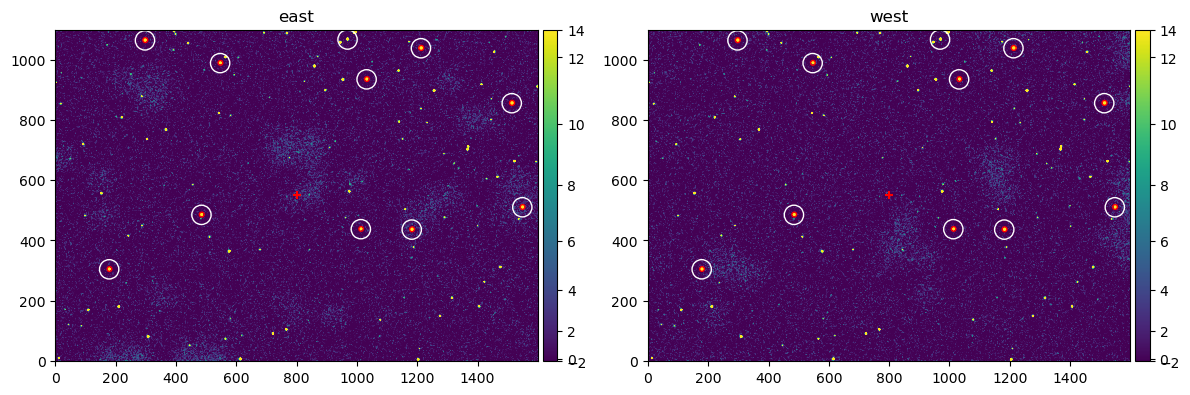

CancelledError: 

In [8]:

#%matplotlib widget
%matplotlib inline
#%matplotlib notebook

threshold = 3.2
minarea = 24.0
deblend_nthresh = 1.2
deblend_cont = 0.01

num_stars = 4

source_detection = SepSourceDetection(threshold=threshold, minarea=minarea, deblend_nthresh=deblend_nthresh, deblend_cont=deblend_cont)


async def expose(time):
    filenames = (await lvm.sci.agc.expose(time)).flatten().unpack("*.filename") 
    images=[]
    for f in filenames:
        img = Image.from_file(f)
        img.wcs = wcs.WCS(img.header)
        images.append(img)
    return [images[0], images[2]]


def filter(image):
        image.data = median_filter(image.data, size=2)
        
        # photutils.background
#        bkg_estimator = MedianBackground()
#        bkg = Background2D(image.data.astype(float), (50, 50), filter_size=(3, 3),
#                           bkg_estimator=bkg_estimator)
#        bkg_median = np.median(bkg.background)
#        bkg_std = np.std(bkg.background)
#        image.data = image.data.astype(float) - bkg.background

        # sep.background
        bkg = sep.Background(image.data.astype(float))
        bkg_median = np.median(bkg)
        bkg_std = np.std(bkg_median)
        image.data = image.data.astype(float) - bkg
        image.header["BKGMED"]=bkg_median
        image.header["BKGSTD"]=bkg_std
#        print(f"median {bkg_median}, std {bkg_std}")

        return image

async def detect(image):
        wcs = image.wcs
        image = await source_detection(image)
        image.wcs = wcs
#        image.catalog.sort("fwhm")
        image.catalog = image.catalog[image.catalog["peak"] > image.header["BKGMED"]*2]
        image.catalog = image.catalog[image.catalog["ellipticity"] < 0.35]
#        image.catalog = image.catalog[image.catalog["fwhm"] > 8]
#        image.catalog = image.catalog[image.catalog["peak"] > 50]
        image.catalog = image.catalog[image.catalog["peak"] < 60000]
        image.catalog.sort("peak")
        image.catalog.reverse()
        return image
    
max_sources=10
search_boxsize=17

async def centroid(image, sources=None, centroid_func=centroid_com):

        if sources is None:
           sources = np.array([image.catalog['x'], 
                               image.catalog['y']])
        try:
            x, y = centroid_sources(image.data,
                                    sources[0],
                                    sources[1],
                                    box_size=search_boxsize,
                                    centroid_func=centroid_func)
            image.centroid = np.array([x, y])

        except Exception as ex:
            print("Error: no sources")

        return image

async def offset_simple(images, ref_images, guide_on, centroid_func=centroid_com):

    diff_centroid = [None] * len(images)
    for idx, img in enumerate(images):
        images[idx] = filter(images[idx])
        images[idx] = await detect(images[idx])
        await centroid(images[idx], sources=ref_images[idx].centroid, centroid_func=centroid_func)
        print(len(images[idx].centroid.T))

        diff_centroid[idx] = (ref_images[idx].centroid - images[idx].centroid).transpose()
        print(f" centroids {len(ref_images[idx].centroid.T)}:{len(images[idx].centroid.T)}")
#        print(f" centroids {ref_images[idx].centroid.T}:{images[idx].centroid.T}")
        print(f" centroids {diff_centroid[idx]}")

    cen_diff =  np.concatenate([diff_centroid[idx] for idx in range(len(images))])
    cen_min = np.min(cen_diff, axis=0)
    cen_max = np.max(cen_diff, axis=0)
    cen_median = np.median(cen_diff, axis=0)
    cen_std = np.std(cen_diff, axis=0)
    print(f"\nmedian centroid diff {cen_min} {cen_median} {cen_max} {cen_std}")

    offset = np.array([cen_median[1], cen_median[0]])
    offset *= [images[0].header['BINX'], images[0].header['BINY']]
    offset *= [images[0].header['PIXSCALE'], images[0].header['PIXSCALE']]
    offset /= [cos(np.deg2rad(images[0].header['DEC'])), 1.0]
    offset *= [-0.95, 0.95]
    print(f"offset radec diff {offset}")

    if guide_on:
        if (abs(offset) > [0.5, 0.5]).any():
            print(f"correcting {offset}")
            await lvm.sci.pwi.offset(ra_add_arcsec = offset[0], 
                                     dec_add_arcsec = offset[1])

async def offset_radec(images, ref_images, guide_on):

    diff_centroid = [None] * len(images)
    for idx, img in enumerate(images):
        images[idx] = filter(images[idx])
        images[idx] = await detect(images[idx])
        await centroid(images[idx], sources=ref_images[idx].centroid)

        
    cen_diff =  np.median(np.concatenate([diff_centroid[idx] for idx in range(len(images))]), axis=0)
    print(f"\nmedian centroid diff {cen_diff}")

    if guide_on:
        if (abs(offset) > [0.5, 0.5]).any():
            print(f"correcting {offset}")
            await lvm.sci.pwi.offset(ra_add_arcsec = offset[0], 
                                     dec_add_arcsec = offset[1])

loop = True

exp_time = 1.0
column = "fwhm"
centroid_func = centroid_com
#centroid_func = centroid_2dg
#centroid_func = centroid_quadratic

ref_images = await expose(exp_time)

for idx, img in enumerate(ref_images):
    ref_images[idx] = filter(ref_images[idx])
    ref_images[idx] = await detect(ref_images[idx])

    await centroid(ref_images[idx], centroid_func=centroid_func)

plot_images(ref_images, cat_max=max_sources, cat_rest=True, figsize=(12, 10))

if not hasattr(ref_images[0], "centroid"):
    loop = False

guide_on = False

while loop:
    await lvm.sci.pwi.status()
    await lvm.sci.km.status()
    await lvm.sci.foc.status()

    images = await expose(exp_time)

    clear_output(wait=True)
    await offset_simple(images, ref_images, guide_on, centroid_func=centroid_func)
    
    plot_images(images, cat_max=max_sources, cat_rest=False, figsize=(12,10))
    await asyncio.sleep(5.0)


In [11]:
await lvm.sci.pwi.status()
await lvm.sci.km.status()
await lvm.sci.foc.status()

exp_time=2
ref_images = await expose(exp_time)
for idx, img in enumerate(ref_images):
    ref_images[idx] = filter(ref_images[idx])
    ref_images[idx] = await detect(ref_images[idx])

    await centroid(ref_images[idx])

r_img=ref_images[0]

#print(r_img.centroid.T[:4])

images = await expose(exp_time)

for idx, img in enumerate(images):
    images[idx] = filter(images[idx])
    images[idx] = await detect(images[idx])

    await centroid(images[idx], sources=ref_images[idx].centroid)

img=images[0]

r_sky = [SkyCoord(*r_img.wcs.all_pix2world(x, y, 1, ra_dec_order=True), unit="deg") for x, y in r_img.centroid.T]
i_sky = [SkyCoord(*img.wcs.all_pix2world(x, y, 1, ra_dec_order=True), unit="deg") for x, y in img.centroid.T]
i_diff = [r_s.spherical_offsets_to(i_sky[idx]) for idx, r_s in enumerate(r_sky)]
print(i_diff)
a=i_diff[1]
a[0]

r_cen = img.wcs.all_pix2world(r_img.centroid[0], r_img.centroid[1], 1, ra_dec_order=True)
i_cen = img.wcs.all_pix2world(img.centroid[0], img.centroid[1], 1, ra_dec_order=True)
r_sky = SkyCoord(r_cen[0], r_cen[1], unit="deg")
i_sky = SkyCoord(i_cen[0], i_cen[1], unit="deg")
r_sky.spherical_offsets_to(i_sky)


[WARNING]: 'obsfix' made the change 'Set OBSGEO-L to     8.724000 from OBSGEO-[XYZ]. (FITSFixedWarning)
[WARNING]: 'obsfix' made the change 'Set OBSGEO-L to     8.724000 from OBSGEO-[XYZ]. (FITSFixedWarning)


[(<Angle 2.17775898e-05 deg>, <Angle 6.9350296e-05 deg>), (<Angle 3.60443997e-05 deg>, <Angle 6.21053784e-05 deg>), (<Angle -2.12445513e-05 deg>, <Angle 7.59204674e-05 deg>), (<Angle 1.18877645e-05 deg>, <Angle 3.06665395e-05 deg>), (<Angle -3.53409547e-05 deg>, <Angle 3.91673375e-05 deg>), (<Angle -4.11442342e-05 deg>, <Angle 4.68358634e-05 deg>), (<Angle -3.68953142e-06 deg>, <Angle 2.92010783e-05 deg>), (<Angle 4.93544278e-06 deg>, <Angle 6.16229162e-05 deg>), (<Angle 2.15082326e-05 deg>, <Angle 4.19557756e-05 deg>), (<Angle -9.79991404e-06 deg>, <Angle 6.31428182e-05 deg>), (<Angle 7.22906442e-06 deg>, <Angle 2.67486878e-05 deg>), (<Angle -3.68868674e-05 deg>, <Angle 6.31534672e-05 deg>), (<Angle 4.49504684e-05 deg>, <Angle 6.23057988e-05 deg>), (<Angle 2.08471112e-05 deg>, <Angle 8.31860257e-05 deg>), (<Angle 1.63006203e-05 deg>, <Angle 2.51118574e-05 deg>), (<Angle -4.75185573e-05 deg>, <Angle 5.2428972e-05 deg>)]
(array([279.70759023, 279.77578753, 279.69072323, 279.92381902,
  

(<Angle [ 1.54204330e-05,  2.65916963e-05, -1.80334534e-05,  6.04094254e-06,
         -3.06455138e-05, -3.47207182e-05, -2.25668644e-06,  4.94259365e-07,
          1.18016558e-05, -9.17675565e-06,  3.15016815e-06, -4.07044487e-05,
          4.23093840e-05,  1.40805613e-05,  1.97198568e-05, -4.70811649e-05] deg>,
 <Angle [8.30975787e-05, 7.78395094e-05, 8.91765115e-05, 5.07135168e-05,
         6.03247716e-05, 6.33242704e-05, 4.85514505e-05, 7.64088895e-05,
         6.13233011e-05, 7.72463831e-05, 4.67361956e-05, 7.65403184e-05,
         7.66002779e-05, 9.84262432e-05, 4.86412170e-05, 6.63396892e-05] deg>)